# Comparing fractional crystallization in different models

- One of the primary uses of the MELTS thermodynamic models is simulating the crystallization of magma under different conditions. PetThermoTools means you can now easily compare different models

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files. Please see the installation guide on ReadTheDocs.

Data used in the calculations below can be downloaded from here: https://github.com/gleesonm1/PetThermoTools/blob/master/docs/Examples/CrystallisationTests/Fernandina_glass.xlsx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If the alphaMELTS for Python files have not been added to your Python path (see installation guide) then use the two lines below to add
# the location of the alphaMELTS files here.
import sys
sys.path.append(r'C:\Users\penny\Box\Berkeley_new\MELTS_Installation\alphamelts_py\alphamelts-py-2.3.1-win64')

# Now run this and itll check you have added it properly
import petthermotools as ptt

In [2]:
# If you've not done this in a while...wh
#ptt.update_MAGEMinCalc()

In [3]:
ptt.__version__

'0.3.0'

In [4]:
# Should be used to suppress outputs on MacOS - run twice
import platform
if platform.system() == "Darwin":
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

In this notebook we'll show how PetThermoTools can quickly perform multiple calculations (utilizing parallel processing), and investigate how the liquid-line-of-descent is linked to the conditions of magma storage, and most importantly, the choice of thermodynamic model!

First, we need to load in some data. For this example we'll use data from Isla Fernandina in the Galapagos Archipelago, where a series of melt inclusions (Koleszar et al. 2009) and matrix glasses (Peterson et al. 2017) provide us with plenty of glass data to constain the magmatic evolution of the sub-volcanic system. The melt inclusion and matrix glass data is included in a single excel spreadsheet that we can load in using Pandas. We can also split this DataFrame into two. One containing just the melt inclusion data, the second including just the matrix glass data.

In [5]:
df = pd.read_excel('Fernandina_glass.xlsx')
df = df.fillna(0)

# split data based on the Group (Melt Inclusion or Matrix Glass)
MI = df.loc[df['Group'] == 'MI',:].reset_index(drop = True)
MG = df.loc[df['Group'] == 'MG',:].reset_index(drop = True)

MG.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MG,-0.17,-91.77,49.11,2.90,14.04,11.38,0.21,6.53,11.88,2.55,0.43,0.30,0.593,0.011442
1,MG,-0.17,-91.77,49.22,3.10,14.09,11.37,0.20,6.75,11.78,2.75,0.44,0.31,0.683,0.009890
2,MG,-0.21,-91.81,49.01,2.92,13.92,11.74,0.21,6.31,11.90,2.55,0.46,0.33,0.635,0.012210
3,MG,-0.21,-91.80,49.42,3.14,13.92,11.77,0.20,6.47,11.46,2.82,0.46,0.33,0.732,0.010531
4,MG,-0.24,-91.75,48.76,3.57,13.88,11.83,0.23,6.37,11.40,3.09,0.52,0.36,0.834,0.007797


One of the key things that we need to perform any calculations with MELTS is a starting composition. To start, let's use the most primitive (highest MgO) composition from the melt inclusion analyses. There are a few ways to find this composition, the way I like to do so (not necessarily the quickest) is to simply sort the melt inclusion DataFrame by the MgO contents and select the first row:

In [6]:
MI = MI.sort_values('MgO', ascending = False, ignore_index = True)
MI.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MI,0.0,0.0,47.5,2.29,16.4,9.16,0.123,9.38,11.6,2.25,0.329,0.257,0.68,0.0280
1,MI,0.0,0.0,47.5,2.58,15.5,10.04,0.138,8.97,11.4,2.44,0.428,0.262,0.69,0.0630
2,MI,0.0,0.0,49.2,2.33,16.0,8.67,0.147,8.94,12.0,1.78,0.005,0.094,0.78,0.0004
3,MI,0.0,0.0,48.4,2.50,15.7,9.07,0.139,8.88,11.6,2.18,0.398,0.326,0.69,0.0126
4,MI,0.0,0.0,48.1,2.46,15.3,8.96,0.153,8.82,12.1,2.34,0.325,0.387,0.88,0.4986


In [ ]:
starting_comp = MI.loc[0]
type(starting_comp)


# To Clarify, in the YouTube example I ran the model without any Cr. I have now added 0.05 wt%. You can see MAGEMin puts it in the Cpx but MELTS doesnt. 
starting_comp['Cr2O3']=0.05

C:\Users\penny\AppData\Local\Temp\ipykernel_29360\970330252.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starting_comp['Cr2O3']=0.05
C:\Users\penny\AppData\Local\Temp\ipykernel_29360\970330252.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  starting_comp['Cr2O3']=0.05


We can now perform crystallisation calculations. These calculations are run using rhyoliteMELTSv1.2.0 (we have some CO$_2$ in the starting composition), start at the liquidus and end at 1100$^o$C. The calculations are also run at 1 log unit below the FMQ buffer. By specifying Frac_solid = True, we inform PetThermoTools that we want to perform a fractional (rather than equilibrium) crystallisation scenario.

In [8]:
Isobaric_Xtal_120 = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_bar = np.array([500,3000]),
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "P_bar")

Completed 100.0 %


Now lets use pMELTS

In [9]:
Isobaric_Xtal_pMELTS = ptt.isobaric_crystallisation(Model = "pMELTS",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_bar = np.array([500,3000]),
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "P_bar")

Completed 100.0 %


And now melts 1.0.2

In [10]:
Isobaric_Xtal_102 = ptt.isobaric_crystallisation(Model = "MELTSv1.0.2",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_bar = np.array([500,3000]),
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "P_bar")

Completed 100.0 %


and now Green et al. (2025) e.g. the update of the Holland models run through MageMIN

In [11]:
# Takes 30 s to initialize Julia. So be patient and try to run everything in one model. 
Isobaric_Xtal_Green2025 = ptt.isobaric_crystallisation(Model = "Green2025",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_bar = np.array([500,3000]),
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "P_bar")

Completed 100.0 %


## Lets make a nice figure showing chemistry for these

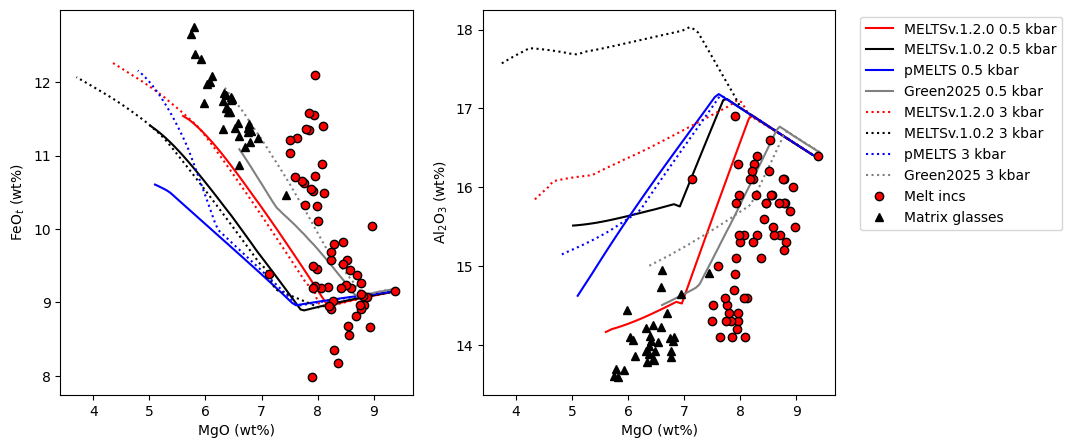

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))



# plot various models at 0.5 kbar

ax1.plot(Isobaric_Xtal_120['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_120['P = 500.0 bars']['All']['FeOt_Liq'], '-r', label='MELTSv.1.2.0 0.5 kbar')
ax1.plot(Isobaric_Xtal_102['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_102['P = 500.0 bars']['All']['FeOt_Liq'], '-k', label='MELTSv.1.0.2 0.5 kbar')
ax1.plot(Isobaric_Xtal_pMELTS['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_pMELTS['P = 500.0 bars']['All']['FeOt_Liq'], '-b', label='MELTSv.1.2.0 0.5 kbar')
ax1.plot(Isobaric_Xtal_Green2025['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_Green2025['P = 500.0 bars']['All']['FeOt_Liq'], '-', color='grey', label='Green2025 0.5 kbar')

# same for 3000 bars

ax1.plot(Isobaric_Xtal_120['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_120['P = 3000.0 bars']['All']['FeOt_Liq'], ':r', label='MELTSv.1.2.0 3 kbar')
ax1.plot(Isobaric_Xtal_102['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_102['P = 3000.0 bars']['All']['FeOt_Liq'], ':k', label='MELTSv.1.0.2 3 kbar')
ax1.plot(Isobaric_Xtal_pMELTS['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_pMELTS['P = 3000.0 bars']['All']['FeOt_Liq'], ':b', label='MELTSv.1.2.0 3 kbar')
ax1.plot(Isobaric_Xtal_Green2025['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_Green2025['P = 3000.0 bars']['All']['FeOt_Liq'], ':', color='grey', label='Green2025 3 kbar')
ax1.set_ylabel('FeO$_t$ (wt%)')
ax1.set_xlabel('MgO (wt%)')

## Same for Al2O3

ax2.plot(Isobaric_Xtal_120['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_120['P = 500.0 bars']['All']['Al2O3_Liq'], '-r', label='MELTSv.1.2.0 0.5 kbar')
ax2.plot(Isobaric_Xtal_102['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_102['P = 500.0 bars']['All']['Al2O3_Liq'], '-k', label='MELTSv.1.0.2 0.5 kbar')
ax2.plot(Isobaric_Xtal_pMELTS['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_pMELTS['P = 500.0 bars']['All']['Al2O3_Liq'], '-b', label='pMELTS 0.5 kbar')
ax2.plot(Isobaric_Xtal_Green2025['P = 500.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_Green2025['P = 500.0 bars']['All']['Al2O3_Liq'], '-', color='grey', label='Green2025 0.5 kbar')

# same for 3000 bars

ax2.plot(Isobaric_Xtal_120['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_120['P = 3000.0 bars']['All']['Al2O3_Liq'], ':r', label='MELTSv.1.2.0 3 kbar')
ax2.plot(Isobaric_Xtal_102['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_102['P = 3000.0 bars']['All']['Al2O3_Liq'], ':k', label='MELTSv.1.0.2 3 kbar')
ax2.plot(Isobaric_Xtal_pMELTS['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_pMELTS['P = 3000.0 bars']['All']['Al2O3_Liq'], ':b', label='pMELTS 3 kbar')
ax2.plot(Isobaric_Xtal_Green2025['P = 3000.0 bars']['All']['MgO_Liq'], Isobaric_Xtal_Green2025['P = 3000.0 bars']['All']['Al2O3_Liq'], ':', color='grey', label='Green2025 3 kbar')
ax2.set_xlabel('MgO (wt%)')
ax2.set_ylabel('Al$_2$O$_3$ (wt%)')


# Plot melt inclusion and matrix glass data 
ax1.plot(MI['MgO'], MI['FeOt'], 'ok', mfc='red', label='Melt incs')
ax1.plot(MG['MgO'], MG['FeOt'], '^k', mfc='k', label='Matrix glasses')


# Plot melt inclusion and matrix glass data 
ax2.plot(MI['MgO'], MI['Al2O3'], 'ok', mfc='red', label='Melt incs')
ax2.plot(MG['MgO'], MG['Al2O3'], '^k', mfc='k', label='Matrix glasses')


ax2.legend(
    fontsize=10,
    ncol=1,
    loc='upper left',
    bbox_to_anchor=(1.05, 1)
)

In [13]:
Isobaric_Xtal_Green2025['P = 500.0 bars']['mass_g'].columns

Index(['clinopyroxene1', 'olivine1', 'feldspar1', 'liquid1',
       'clinopyroxene1_cumsum', 'olivine1_cumsum', 'feldspar1_cumsum'],
      dtype='object')

In [14]:
Isobaric_Xtal_120['P = 500.0 bars']['mass_g'].columns

Index(['liquid1', 'olivine1', 'fluid1', 'plagioclase1', 'spinel1',
       'clinopyroxene1', 'clinopyroxene2', 'olivine1_cumsum', 'fluid1_cumsum',
       'plagioclase1_cumsum', 'spinel1_cumsum', 'clinopyroxene1_cumsum',
       'clinopyroxene2_cumsum'],
      dtype='object')

## Lets look at the phase proportions

Text(0.5, 0, 'MgO (wt%) in melt')

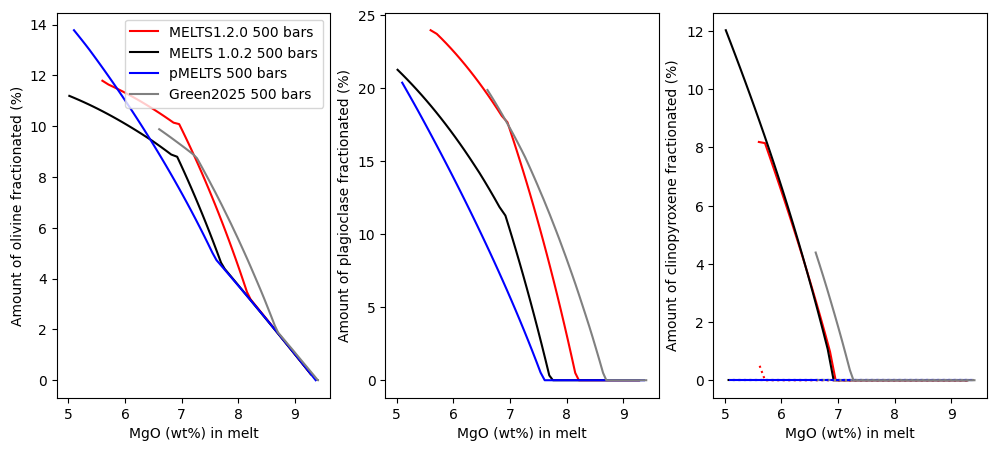

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,5))

# Lets loop through all the models
models=[Isobaric_Xtal_120['P = 500.0 bars'], Isobaric_Xtal_102['P = 500.0 bars'],
Isobaric_Xtal_pMELTS['P = 500.0 bars'], Isobaric_Xtal_Green2025['P = 500.0 bars'] ]
labels=['MELTS1.2.0 500 bars', 'MELTS 1.0.2 500 bars', 'pMELTS 500 bars', 'Green2025 500 bars']
cols=['r', 'k', 'b', 'grey']

for model, label, col in zip(models, labels, cols):
    mg = model['All']['MgO_Liq']

    # Plot olivine (or zeros if missing)
    if 'olivine1_cumsum' in model['mass_g'].columns:
        y_ol = model['mass_g']['olivine1_cumsum']
    else:
        y_ol = [0] * len(mg)
    ax1.plot(mg, y_ol, '-', color=col, label=label)

    # Plot plagioclase (or zeros if missing)
    if 'plagioclase1_cumsum' in model['mass_g'].columns:
        y_plag = model['mass_g']['plagioclase1_cumsum']
    elif 'feldspar1_cumsum' in model['mass_g'].columns:
        y_plag = model['mass_g']['feldspar1_cumsum']
    else:
        y_plag = [0] * len(mg)
    ax2.plot(mg, y_plag, '-', color=col, label=label)

    # Plot clinopyroxene (or zeros if missing)
    if 'clinopyroxene1_cumsum' in model['mass_g'].columns:
        y_cpx = model['mass_g']['clinopyroxene1_cumsum']
    else:
        y_cpx = [0] * len(mg)
    ax3.plot(mg, y_cpx, '-', color=col, label=label)


    if 'clinopyroxene2_cumsum' in model['mass_g'].columns:
        y_cpx2 = model['mass_g']['clinopyroxene2_cumsum']
    else:
        y_cpx2 = [0] * len(mg)
    ax3.plot(mg, y_cpx2, ':', color=col, label=label)
    

ax1.legend()
ax1.set_ylabel('Amount of olivine fractionated (%)')
ax1.set_xlabel('MgO (wt%) in melt')


ax2.set_ylabel('Amount of plagioclase fractionated (%)')
ax2.set_xlabel('MgO (wt%) in melt')

ax3.set_ylabel('Amount of clinopyroxene fractionated (%)')
ax3.set_xlabel('MgO (wt%) in melt')

Lets see what phases are present at 3000 bars

In [16]:
Isobaric_Xtal_120['P = 3000.0 bars']['mass_g'].columns

Index(['liquid1', 'olivine1', 'spinel1', 'clinopyroxene1', 'plagioclase1',
       'clinopyroxene2', 'rhm-oxide1', 'olivine1_cumsum', 'spinel1_cumsum',
       'clinopyroxene1_cumsum', 'plagioclase1_cumsum', 'clinopyroxene2_cumsum',
       'rhm-oxide1_cumsum'],
      dtype='object')

In [17]:
Isobaric_Xtal_Green2025['P = 3000.0 bars']['mass_g'].columns

Index(['clinopyroxene1', 'olivine1', 'feldspar1', 'liquid1', 'spinel1',
       'clinopyroxene1_cumsum', 'olivine1_cumsum', 'feldspar1_cumsum',
       'spinel1_cumsum'],
      dtype='object')

## And plot phase abundances at 3000 bars

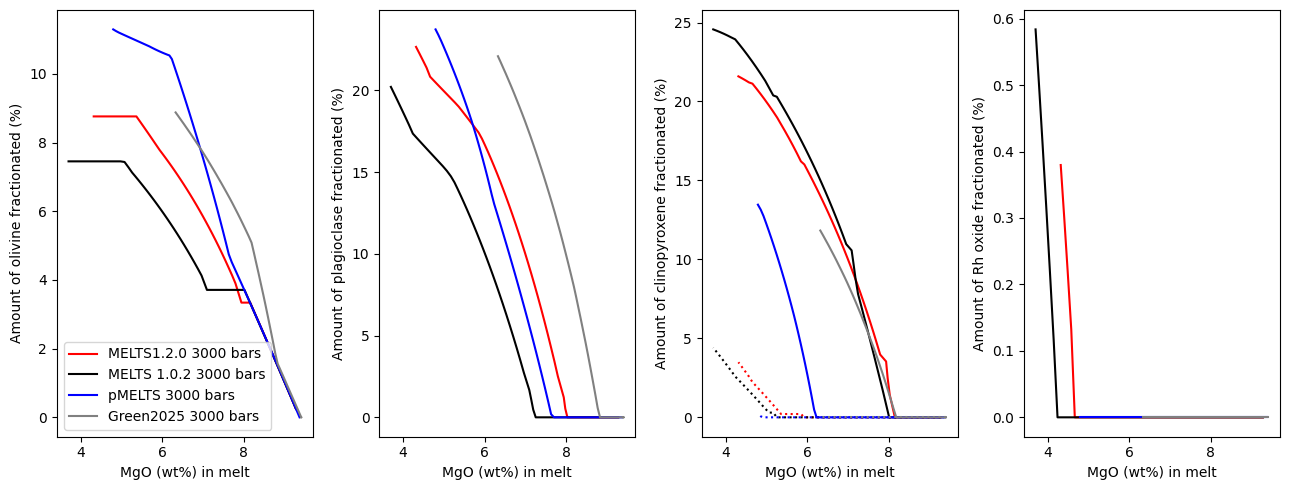

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (13,5))

# Lets loop through all the models
models=[Isobaric_Xtal_120['P = 3000.0 bars'], Isobaric_Xtal_102['P = 3000.0 bars'],
Isobaric_Xtal_pMELTS['P = 3000.0 bars'], Isobaric_Xtal_Green2025['P = 3000.0 bars'] ]
labels=['MELTS1.2.0 3000 bars', 'MELTS 1.0.2 3000 bars', 'pMELTS 3000 bars', 'Green2025 3000 bars']
cols=['r', 'k', 'b', 'grey']

for model, label, col in zip(models, labels, cols):
    mg = model['All']['MgO_Liq']

    # Plot olivine (or zeros if missing)
    if 'olivine1_cumsum' in model['mass_g'].columns:
        y_ol = model['mass_g']['olivine1_cumsum']
    else:
        y_ol = [0] * len(mg)
    ax1.plot(mg, y_ol, '-', color=col, label=label)

    # Plot plagioclase (or zeros if missing)
    if 'plagioclase1_cumsum' in model['mass_g'].columns:
        y_plag = model['mass_g']['plagioclase1_cumsum']
    elif 'feldspar1_cumsum' in model['mass_g'].columns:
        y_plag = model['mass_g']['feldspar1_cumsum']
    else:
        y_plag = [0] * len(mg)
    ax2.plot(mg, y_plag, '-', color=col, label=label)

    # Plot clinopyroxene (or zeros if missing)
    if 'clinopyroxene1_cumsum' in model['mass_g'].columns:
        y_cpx = model['mass_g']['clinopyroxene1_cumsum']
    else:
        y_cpx = [0] * len(mg)
    ax3.plot(mg, y_cpx, '-', color=col, label=label)


    if 'clinopyroxene2_cumsum' in model['mass_g'].columns:
        y_cpx2 = model['mass_g']['clinopyroxene2_cumsum']
    else:
        y_cpx2 = [0] * len(mg)
    ax3.plot(mg, y_cpx2, ':', color=col, label=label)

    # Plot Rho oxide (or zeros if missing)
    if 'rhm-oxide1_cumsum' in model['mass_g'].columns:
        y_rh = model['mass_g']['rhm-oxide1_cumsum']
    else:
        y_rh = [0] * len(mg)
    ax4.plot(mg, y_rh, '-', color=col, label=label)
    

ax1.legend()
ax1.set_ylabel('Amount of olivine fractionated (%)')
ax1.set_xlabel('MgO (wt%) in melt')


ax2.set_ylabel('Amount of plagioclase fractionated (%)')
ax2.set_xlabel('MgO (wt%) in melt')

ax3.set_ylabel('Amount of clinopyroxene fractionated (%)')
ax3.set_xlabel('MgO (wt%) in melt')

ax4.set_ylabel('Amount of Rh oxide fractionated (%)')
ax4.set_xlabel('MgO (wt%) in melt')

fig.tight_layout()

## Whats up with Cpx2? 

In [19]:
# Lets import thermobar, you will need to pip install if you havent already
#!pip install Thermobar
import Thermobar as pt
# you'll also need to import ternary
import ternary

In [20]:
df_Cpx1=Isobaric_Xtal_120['P = 500.0 bars']['clinopyroxene1']
tern_points_Cpx1=pt.tern_points_px(px_comps=df_Cpx1)
# Remove the 2 before doing the same for Px2
df_Cpx2=Isobaric_Xtal_120['P = 500.0 bars']['clinopyroxene2']
df_Cpx2.columns = df_Cpx2.columns.str.replace('Cpx2', 'Cpx', regex=False)
tern_points_Cpx2=pt.tern_points_px(px_comps=df_Cpx2)


c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


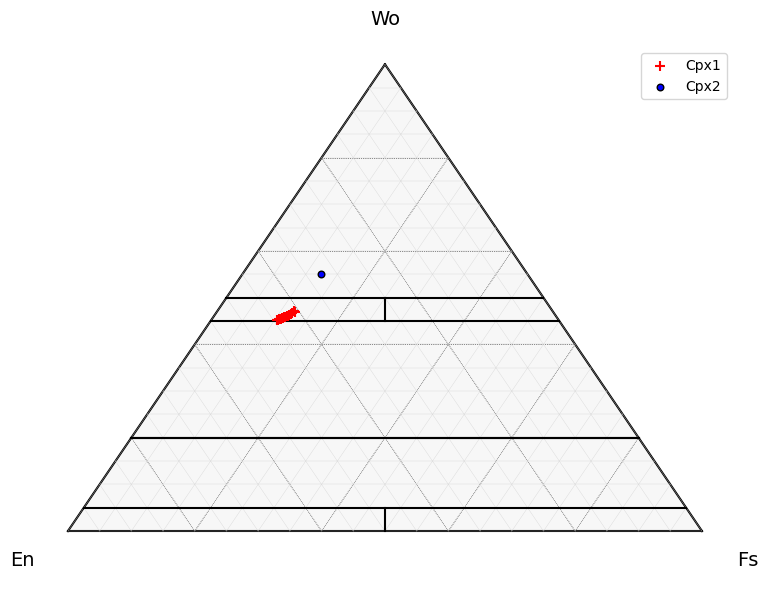

In [21]:
# First, define the plot, e.g., here, we specify we want the grid, and labels
fig, tax = pt.plot_px_classification(figsize=(9, 7),  fontsize_component_labels=12,
                                     major_grid=True, minor_grid=True,  cut_in_half=False)

## Now feed in your data we calculated at the start in terms of ternary axes!

tax.scatter(
    tern_points_Cpx1,
    edgecolor="k",
    marker="+",
    facecolor="red",
    label='Cpx1',
   s=60
)

tax.scatter(
    tern_points_Cpx2,
    edgecolor="k",
    marker=".",
    facecolor="blue",
    label='Cpx2',
   s=90
)
tax.legend()

## Lets compare the Cpx (all from each model)

c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the fut

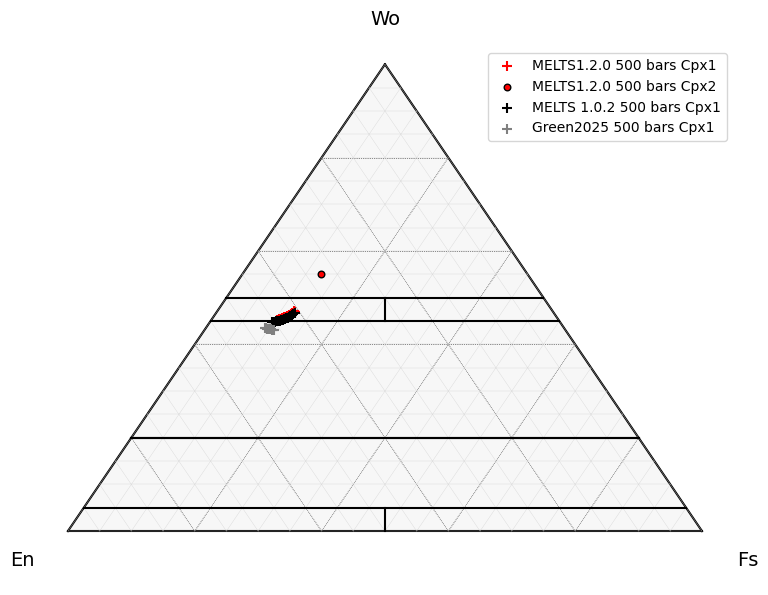

In [22]:
import matplotlib.pyplot as plt

# ---------------------------------------
# Your models, labels, and colors
# ---------------------------------------
models = [
    Isobaric_Xtal_120['P = 500.0 bars'],
    Isobaric_Xtal_102['P = 500.0 bars'],
    Isobaric_Xtal_pMELTS['P = 500.0 bars'],
    Isobaric_Xtal_Green2025['P = 500.0 bars'],
]

labels = [
    'MELTS1.2.0 500 bars',
    'MELTS 1.0.2 500 bars',
    'pMELTS 500 bars',
    'Green2025 500 bars',
]

cols = ['r', 'k', 'b', 'grey']

# ---------------------------------------
# Make classification figure
# ---------------------------------------
fig, tax = pt.plot_px_classification(
    figsize=(9, 7),
    fontsize_component_labels=12,
    major_grid=True,
    minor_grid=True,
    cut_in_half=False,
)

# ---------------------------------------
# Loop through models
# ---------------------------------------
for model, lab, col in zip(models, labels, cols):

    # ---- Cpx1 ----
    if "clinopyroxene1" in model:
        df_Cpx1 = model["clinopyroxene1"]
        tern_Cpx1 = pt.tern_points_px(px_comps=df_Cpx1)

        tax.scatter(
            tern_Cpx1,
            edgecolor="k",
            marker="+",
            facecolor=col,
            label=f"{lab} Cpx1",
            s=60,
        )

    # ---- Cpx2 ----
    if "clinopyroxene2" in model:
        df_Cpx2 = model["clinopyroxene2"].copy()

        # Only do the rename if any column contains Cpx2
        if df_Cpx2.columns.str.contains("Cpx2").any():
            df_Cpx2.columns = df_Cpx2.columns.str.replace("Cpx2", "Cpx", regex=False)

        tern_Cpx2 = pt.tern_points_px(px_comps=df_Cpx2)

        tax.scatter(
            tern_Cpx2,
            edgecolor="k",
            marker=".",
            facecolor=col,
            label=f"{lab} Cpx2",
            s=90,
        )

# ---------------------------------------
# Legend + show
# ---------------------------------------
tax.legend()
plt.show()


## Lets plot clinopyroxene components. 

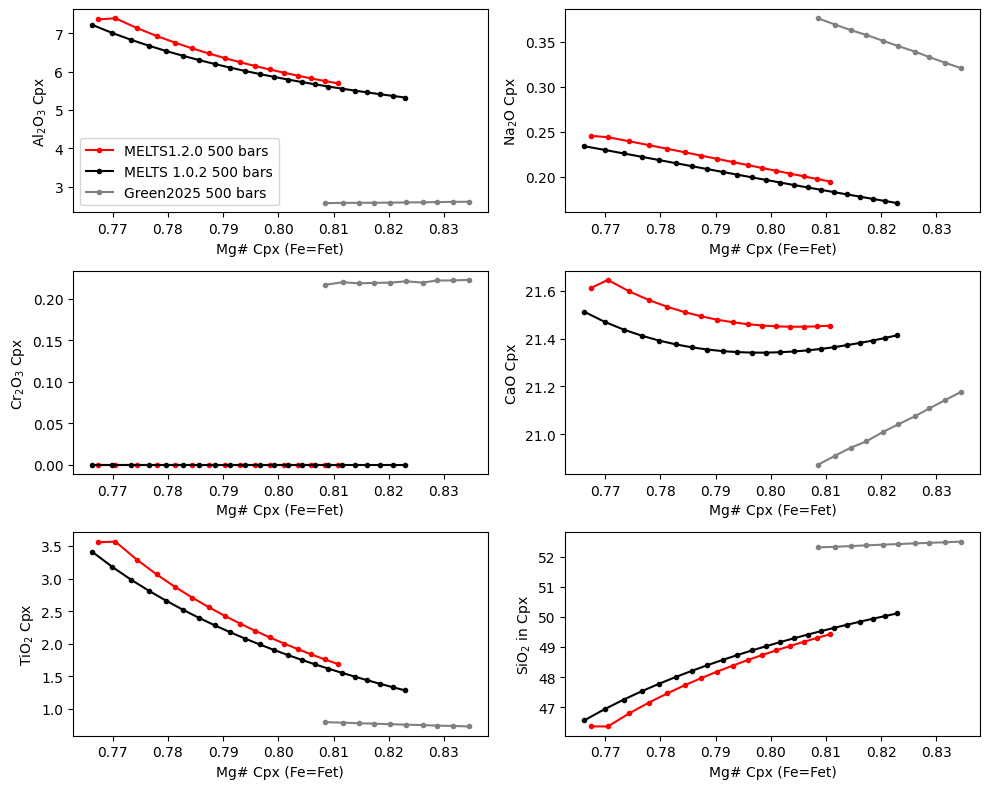

In [23]:
import matplotlib.pyplot as plt

# ---------------------------------------
# Your models, labels, and colors
# ---------------------------------------
models = [
    Isobaric_Xtal_120['P = 500.0 bars'],
    Isobaric_Xtal_102['P = 500.0 bars'],
    Isobaric_Xtal_pMELTS['P = 500.0 bars'],
    Isobaric_Xtal_Green2025['P = 500.0 bars'],
]

labels = [
    'MELTS1.2.0 500 bars',
    'MELTS 1.0.2 500 bars',
    'pMELTS 500 bars',
    'Green2025 500 bars',
]

cols = ['r', 'k', 'b', 'grey']

# ---------------------------------------
# Make figure
# ---------------------------------------
fig, ((ax0, ax01), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(10,8))
# ---------------------------------------
# Loop through models
# ---------------------------------------
for model, lab, col in zip(models, labels, cols):

    # ---- Cpx1 ----
    if "clinopyroxene1" in model:
        df_Cpx1 = model["clinopyroxene1"]
        df_Cpx1_all=model['All']
        cpx_comps=pt.calculate_clinopyroxene_components(cpx_comps=df_Cpx1)
        # Plotting the Al2O3 in Cpx
        ax0.plot(cpx_comps['Mgno_Cpx'], df_Cpx1['Al2O3_Cpx'], '.-', mfc=col, color=col, label=lab)

        # Plotting the Na2O in Cpx
        ax01.plot(cpx_comps['Mgno_Cpx'], df_Cpx1['Na2O_Cpx'], '.-', mfc=col, color=col, label=lab)

        # Plotting the Cr2O3 content - Note, this example has no Cr in the bulk as that leads to instabilities. MELTS wont put it in Cpx, MageMIN will. 
        ax1.plot(cpx_comps['Mgno_Cpx'], df_Cpx1['Cr2O3_Cpx'], '.-', mfc=col, color=col, label=lab)

        # Plotting CaO
        ax2.plot(cpx_comps['Mgno_Cpx'], df_Cpx1['CaO_Cpx'], '.-', mfc=col, color=col, label=lab)

        # Plotting TiO2
        ax3.plot(cpx_comps['Mgno_Cpx'], df_Cpx1['TiO2_Cpx'], '.-', mfc=col, color=col, label=lab)

        # Plotting the Fe3/FeT ratio of the Cpx
        ax4.plot(cpx_comps['Mgno_Cpx'], df_Cpx1['SiO2_Cpx'], '.-', mfc=col, color=col, label=lab)

ax0.set_xlabel('Mg# Cpx (Fe=Fet)')
ax0.set_ylabel('Al$_2$O$_3$ Cpx')
ax0.legend()


ax01.set_xlabel('Mg# Cpx (Fe=Fet)')
ax01.set_ylabel('Na$_2$O Cpx')

ax1.set_xlabel('Mg# Cpx (Fe=Fet)')
ax1.set_ylabel('Cr$_2$O$_3$ Cpx')


ax2.set_xlabel('Mg# Cpx (Fe=Fet)')
ax2.set_ylabel('CaO Cpx')

ax3.set_xlabel('Mg# Cpx (Fe=Fet)')
ax3.set_ylabel('TiO$_2$ Cpx')

ax4.set_xlabel('Mg# Cpx (Fe=Fet)')
ax4.set_ylabel('SiO$_2$ in Cpx')

plt.tight_layout()
fig.savefig('CpxChemistry.png', dpi=300)
            

## Lets do the Cpx components

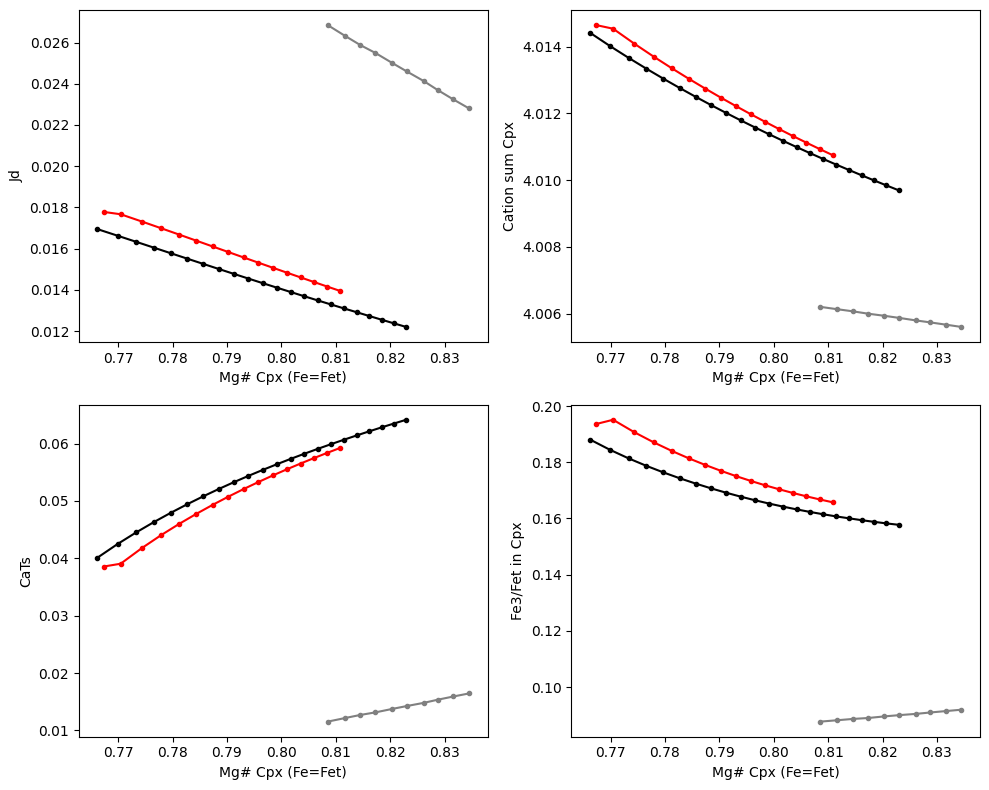

In [24]:
import matplotlib.pyplot as plt

# ---------------------------------------
# Your models, labels, and colors
# ---------------------------------------
models = [
    Isobaric_Xtal_120['P = 500.0 bars'],
    Isobaric_Xtal_102['P = 500.0 bars'],
    Isobaric_Xtal_pMELTS['P = 500.0 bars'],
    Isobaric_Xtal_Green2025['P = 500.0 bars'],
]

labels = [
    'MELTS1.2.0 500 bars',
    'MELTS 1.0.2 500 bars',
    'pMELTS 500 bars',
    'Green2025 500 bars',
]

cols = ['r', 'k', 'b', 'grey']

# ---------------------------------------
# Make figure
# ---------------------------------------
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
# ---------------------------------------
# Loop through models
# ---------------------------------------
for model, lab, col in zip(models, labels, cols):

    # ---- Cpx1 ----
    if "clinopyroxene1" in model:
        df_Cpx1 = model["clinopyroxene1"]
        df_Cpx1_all=model['All']
        cpx_comps=pt.calculate_clinopyroxene_components(cpx_comps=df_Cpx1)
        # Plotting the Al2O3 in Cpx

        # Plotting the Jadiete component of Cpx (related to the Na-Al content)
        ax1.plot(cpx_comps['Mgno_Cpx'], cpx_comps['Jd'], '.-', mfc=col, color=col, label=lab)

        # Plotting the DiHd component (related to Ca, CaTs, CaTi and CrCaTs)
        ax2.plot(cpx_comps['Mgno_Cpx'], cpx_comps['Cation_Sum_Cpx'], '.-', mfc=col, color=col, label=lab)

        # Plotting the CaTs - e.g. excess AlVI after accounting for Jadeite. Al substitution
        ax3.plot(cpx_comps['Mgno_Cpx'], cpx_comps['CaTs'], '.-', mfc=col, color=col, label=lab)

        # Plotting the Fe3/FeT ratio of the Cpx
        ax4.plot(cpx_comps['Mgno_Cpx'], cpx_comps['Fe3Fet_Cpx'], '.-', mfc=col, color=col, label=lab)


ax1.set_xlabel('Mg# Cpx (Fe=Fet)')
ax1.set_ylabel('Jd')


ax2.set_xlabel('Mg# Cpx (Fe=Fet)')
ax2.set_ylabel('Cation sum Cpx')

ax3.set_xlabel('Mg# Cpx (Fe=Fet)')
ax3.set_ylabel('CaTs')

ax4.set_xlabel('Mg# Cpx (Fe=Fet)')
ax4.set_ylabel('Fe3/Fet in Cpx')

plt.tight_layout()
fig.savefig('CpxChemistryComponents.png', dpi=300)
            